In [2]:
import pandas as pd
import numpy as np

# import data 
facturation=pd.read_csv("Bureau/Facturations.csv")
client_to_predict=pd.read_csv("Bureau/Clients_to_complete.csv")
clients=client=pd.read_csv("Bureau/Clients.csv",delimiter=";", encoding='latin-1')

In [2]:
facturation.head()

,product_id,client_id,timestamp
0,21.0,7954279432194,1.486218e+09
1,12.0,10307921510401,1.477860e+09
2,3.0,2843268349952,1.450139e+09
3,90.0,12300786335744,1.479925e+09
4,86.0,1752346656768,1.506672e+09


In [3]:
client_to_predict.head()

,client_id
0,240518168577
1,3659312136192
2,4123168604161
3,7456063225858
4,1829656068096


In [4]:
clients.head()

,client_id,Anciennete,Profession
0,13460427505664,142.0,Menuisier
1,4707284156416,259.0,Platrier
2,2525440770048,36.0,Menuisier
3,16973710753795,216.0,Maçon
4,3642132267010,19.0,Menuisier


In [5]:
facturation.shape, clients.shape, client_to_predict.shape

((58037, 3), (4985, 3), (1265, 1))

In [6]:
# Check unique values
len(facturation['client_id'].unique()),len(client['client_id'].unique()),len(clients['Profession'].unique()),len(facturation['product_id'].unique())

(5973, 4985, 5, 102)

There is 5 class labels in "profession".

Poduct_id can be used as a categorical feature (each class label can be categorized by a type of certain of items).

# joining tables

In [7]:
#Let's check first if there is somme clients to predict in the clients table
# we ll do an inner joing to see if there common client_id s
pd.merge(client_to_predict, clients, how='inner',on='client_id')

,client_id,Anciennete,Profession


In [3]:
left_data=facturation.merge(clients, on='client_id', how='left')
left_data.head()

,product_id,client_id,timestamp,Anciennete,Profession
0,21.0,7954279432194,1.486218e+09,151.0,Menuisier
1,12.0,10307921510401,1.477860e+09,143.0,Platrier
2,3.0,2843268349952,1.450139e+09,NaN,NaN
3,90.0,12300786335744,1.479925e+09,63.0,Platrier
4,86.0,1752346656768,1.506672e+09,NaN,NaN


In [9]:
left_data.isnull().sum()

product_id       53
client_id         0
timestamp       559
Anciennete    13627
Profession    11470
dtype: int64

In [10]:
#we check clients to predict for wich the product_id is null 
# list of clients to predict for wich the product_id is missing
liste1=list(pd.merge(client_to_predict, left_data[left_data.product_id.isnull()], how='inner',on='client_id').client_id)
# list of clients in left_data for wich product_id is not missing
liste2=list(left_data[left_data.product_id.notnull()].client_id)
all(item in liste2 for item in liste1)

True

So here we make sure that we have information on  all the clients to predict existing in left_data.

we made sure earlier that all the clients to predict are not in the client table. So we can't know their "anciennete", we better delet this feature.

In [4]:
left_data=left_data.drop(['timestamp','Anciennete'],axis=1)
left_data.head()

,product_id,client_id,Profession
0,21.0,7954279432194,Menuisier
1,12.0,10307921510401,Platrier
2,3.0,2843268349952,NaN
3,90.0,12300786335744,Platrier
4,86.0,1752346656768,NaN


In [5]:
left_data =left_data.dropna( how='any',subset=['product_id'])
left_data.isnull().sum()

product_id        0
client_id         0
Profession    11458
dtype: int64

# Categorical encoding

In [13]:
left_data['Profession'].unique()

array(['Menuisier', 'Platrier', nan, 'Maçon', 'Couvreur', 'Plombier'],
      dtype=object)

In [6]:
# target variable encoding
left_data = left_data.replace({'Menuisier': 1, 'Platrier':2, 'Maçon':3, 'Plombier':4, 'Couvreur':5})
left_data.head()

,product_id,client_id,Profession
0,21.0,7954279432194,1.0
1,12.0,10307921510401,2.0
2,3.0,2843268349952,NaN
3,90.0,12300786335744,2.0
4,86.0,1752346656768,NaN


In [15]:
pip install --upgrade category_encoders

Note: you may need to restart the kernel to use updated packages.


In [7]:
# product_id oneHotEncoding (we can use other types of encoding for high cordinality data such as hash encoder, but let's try this first)

import category_encoders as ce

encoder=ce.OneHotEncoder(cols='product_id',handle_unknown='return_nan',return_df=True,use_cat_names=True)
left_data = encoder.fit_transform(left_data)

In [8]:
# we separate the into to datasets, for one the professions are missing, and the other they are nots.
null_professions=left_data[left_data.Profession.isnull()]
data_to_use=left_data[left_data.Profession.notnull()]
data_to_use.shape, null_professions.shape

((46526, 103), (11458, 103))

In [9]:
# for each client we want to see all the products he bought, we ll set the values >1 to 1
data_to_use=data_to_use.groupby(['client_id','Profession']).sum().reset_index()
null_professions=null_professions.groupby(['client_id']).sum().reset_index()
data_to_use.shape, null_professions.shape

((4764, 103), (1209, 103))

In [10]:
data_to_use.head()

,client_id,Profession,product_id_21.0,product_id_12.0,product_id_3.0,product_id_90.0,product_id_86.0,product_id_56.0,product_id_97.0,product_id_7.0,...,product_id_51.0,product_id_31.0,product_id_23.0,product_id_5.0,product_id_17.0,product_id_4.0,product_id_15.0,product_id_88.0,product_id_38.0,product_id_100.0
0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,8589934593,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# trasform data to a 0/1 matrix
columns= list(left_data.columns)[:-2]
for col in columns:
  data_to_use[col].values[data_to_use[col]>1]=1
  null_professions[col].values[null_professions[col]>1]=1

# Maching learning

### Split data

In [21]:
data_to_use=data_to_use.drop(['client_id'],1)
training_data=data_to_use.sample(frac=0.75,random_state=25)
testing_data=data_to_use.drop(training_data.index)

print(f"No. of training_data examples: {training_data.shape[0]}")
print(f"No. of testing_data examples: {testing_data.shape[0]}")

X_train=training_data.drop(['Profession'],1)
y_train= training_data['Profession']

X_test=testing_data.drop(['Profession'],1)
y_test=testing_data['Profession']

No. of training_data examples: 3573
No. of testing_data examples: 1191


### Check if data is balanced

In [22]:
(training_data['Profession']).value_counts()

1.0    1717
3.0     598
2.0     574
4.0     401
5.0     283
Name: Profession, dtype: int64

<AxesSubplot:ylabel='Profession'>

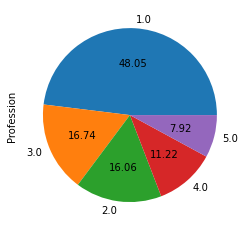

In [23]:
(training_data['Profession']).value_counts().plot.pie(autopct="%.2f")

The data seems to be imbalanced, let's try and balance the training data to see if it will give better results.

In [26]:
from sklearn.utils import resample

df_minority3=training_data.loc[training_data['Profession']==3]
df_minority4=training_data.loc[training_data['Profession']==4]
df_minority5=training_data.loc[training_data['Profession']==5]
df_minority2=training_data.loc[training_data['Profession']==2]
df_majority=training_data[training_data['Profession']==1]

df_minority3_up=resample(df_minority3,replace=True,n_samples=950,random_state=42)
df_minority4_up=resample(df_minority4,replace=True,n_samples=900,random_state=42)
df_minority5_up=resample(df_minority5,replace=True,n_samples=800,random_state=42)
df_minority2_up=resample(df_minority2,replace=True,n_samples=950,random_state=42)
df_majority_down=resample(df_majority,replace=False,n_samples=1400,random_state=42)
data_balanced= pd.concat([df_minority2_up,df_minority3_up,df_minority4_up,df_minority5_up,df_majority], ignore_index=True)
data_balanced.shape

(5317, 102)

<AxesSubplot:ylabel='Profession'>

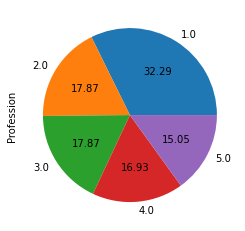

In [28]:
(data_balanced['Profession']).value_counts().plot.pie(autopct="%.2f")

In [29]:
# we'll use same test data
X_trainB=data_balanced.drop(['Profession'],1)
y_trainB=data_balanced['Profession']

Now we'll excute our first model for the balanced and imbalenced data and see which is better to use. 

### SVM

In [30]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)
y_pred = lin_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print('\n')
print(confusion_matrix(y_test, y_pred))

0.6028547439126785


[[521  14  25   8   8]
 [117  40  18   8   2]
 [ 66  16 109   6   2]
 [105   3   6  23   1]
 [ 57   6   1   4  25]]


In [32]:
# with balanced training data
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_trainB, y_trainB)
y_pred1 = lin_clf.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print('\n')
print(confusion_matrix(y_test, y_pred1))

0.5608732157850546


[[393  30  46  54  53]
 [ 72  55  16  27  15]
 [ 42  18 115  15   9]
 [ 58   7   8  60   5]
 [ 27   2   4  15  45]]


well well, i was expecting the labels with less observations to be totaly miss predicted, but this svm seems to be quite good too!

Now let's see if the results will improve once we use balanced data train

I guess we should use other metrics to compare...

In [33]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

labels=['Menuisier','Platrier','Maçon','Plombier','Couvreur']

def metrics_mesures(y_true,predictions):
  print('Accuracy:', metrics.accuracy_score(y_true,predictions))
  print('F1 score:', metrics.f1_score(y_true, predictions,average='micro'))
  print('Recall:', metrics.recall_score(y_true, predictions,average='micro'))
  print('Precision:', metrics.precision_score(y_true, predictions,average='micro'))
  print("\n")
  cm=metrics.confusion_matrix(y_true, predictions)
  df_cm = pd.DataFrame(cm, labels, labels)
  # plt.figure(figsize=(10,7))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}) # font size
  plt.show()

Case of imbalanced data training:

Accuracy: 0.6028547439126785
F1 score: 0.6028547439126785
Recall: 0.6028547439126785
Precision: 0.6028547439126785




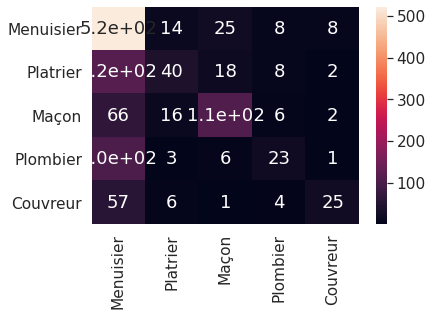

In [34]:
metrics_mesures(y_test,y_pred)

Accuracy: 0.5608732157850546
F1 score: 0.5608732157850546
Recall: 0.5608732157850546
Precision: 0.5608732157850546




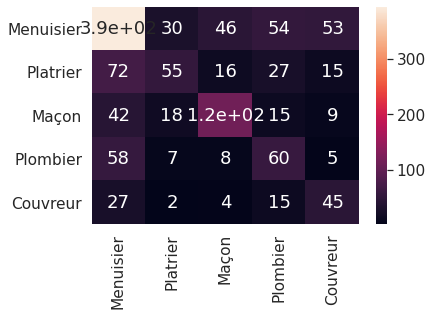

In [35]:
metrics_mesures(y_test,y_pred1)

Looking to the accuracy, we can say that working with training data as it is, the first classifier is more capable of correctly predict new data.

the first classier is also better in term of precision (proportion predictions that where actually correct).
In term of recall the first classfier is still better (proportion of actual labels that where identified correctly). The f1-score is about the same. 

looking to the confusion matrix, we can see that with balanced data, we predict well the labels with few observations, but we loose in term of predictions of the classe 1.

In [36]:
# polynomial svm
poly_clf=SVC(C=1,kernel='poly',degree=2)
poly_clf.fit(X_train,y_train)
y_pred =poly_clf.predict(X_test)
# rbf svm
clf_rbf=SVC(C=1,kernel='rbf',gamma=2)
clf_rbf.fit(X_train,y_train)
y_pred1 =clf_rbf.predict(X_test)

Accuracy: 0.5785054575986566
F1 score: 0.5785054575986566
Recall: 0.5785054575986566
Precision: 0.5785054575986566




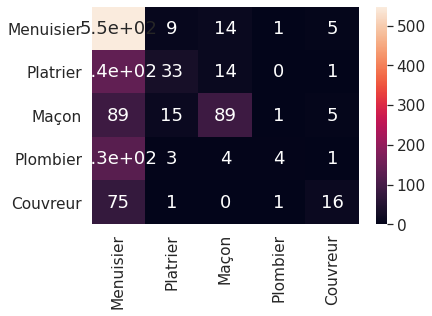

In [37]:
metrics_mesures(y_test,y_pred)

Accuracy: 0.47774979009235935
F1 score: 0.47774979009235935
Recall: 0.47774979009235935
Precision: 0.47774979009235935




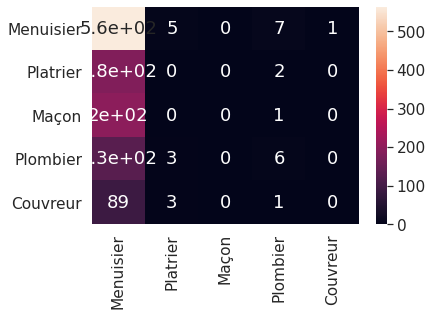

In [38]:
metrics_mesures(y_test,y_pred1)

Looking to the metrics, linear svm is more performant. 

### Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import metrics

def f1(model,x,y):
    return metrics.f1_score(y, model.predict(x),average='micro')

In [44]:
## tuning with RandomizeSearchCV

n_estimators=[100,500,1000]
criterion=['gini','entropy']
max_depth=[20,40,60,100]
max_feature=['sqrt','log2']

param_grid={
    'n_estimators':n_estimators,
    'criterion':criterion,
    'max_depth':max_depth,
    'max_features':max_feature
    
}

Randomiz_rf=RandomizedSearchCV(estimator=RandomForestClassifier(),param_distributions=param_grid,n_iter=50,cv=3,scoring=f1,return_train_score=True,verbose=2)

In [45]:
Randomiz_rf.fit(X_train,y_train)

/home/euclide03/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.6s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.6s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.6s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=500; total time=   2.5s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=500; total time=   2.0s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=500; total time=   1.5s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=1000; total time=   3.2s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=1000; total time=   4.5s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=1000; total time=   5.2s
[CV] END criterion=gini, max_depth=20, max_features=log2, n_estimators=100; tota

[CV] END criterion=entropy, max_depth=20, max_features=log2, n_estimators=500; total time=   1.4s
[CV] END criterion=entropy, max_depth=20, max_features=log2, n_estimators=500; total time=   1.4s
[CV] END criterion=entropy, max_depth=20, max_features=log2, n_estimators=1000; total time=   4.5s
[CV] END criterion=entropy, max_depth=20, max_features=log2, n_estimators=1000; total time=   4.7s
[CV] END criterion=entropy, max_depth=20, max_features=log2, n_estimators=1000; total time=   4.2s
[CV] END criterion=entropy, max_depth=40, max_features=sqrt, n_estimators=100; total time=   0.6s
[CV] END criterion=entropy, max_depth=40, max_features=sqrt, n_estimators=100; total time=   0.7s
[CV] END criterion=entropy, max_depth=40, max_features=sqrt, n_estimators=100; total time=   0.7s
[CV] END criterion=entropy, max_depth=40, max_features=sqrt, n_estimators=500; total time=   3.5s
[CV] END criterion=entropy, max_depth=40, max_features=sqrt, n_estimators=500; total time=   3.4s
[CV] END criterio

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [20, 40, 60, 100],
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': [100, 500, 1000]},
                   return_train_score=True,
                   scoring=<function f1 at 0x7fc6bfcb0820>, verbose=2)

In [46]:
print(Randomiz_rf.best_params_)
print(Randomiz_rf.best_estimator_)

{'n_estimators': 1000, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini'}
RandomForestClassifier(max_depth=20, max_features='sqrt', n_estimators=1000)


In [47]:
random_rf=RandomForestClassifier(criterion='gini',max_depth=20, max_features='sqrt', n_estimators=1000)
random_rf.fit(X_train,y_train)
y_random=random_rf.predict(X_test)

Accuracy: 0.5759865659109992
F1 score: 0.5759865659109992
Recall: 0.5759865659109992
Precision: 0.5759865659109992




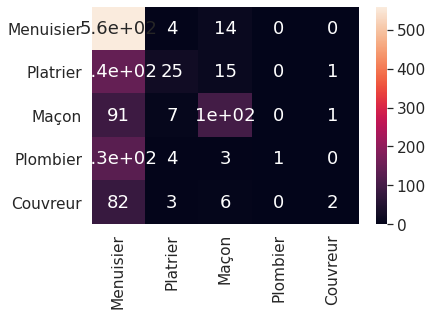

In [48]:
# normaly RandomForest handle imbalanced data
metrics_mesures(y_test,y_random)

Accuracy: 0.5659109991603695
F1 score: 0.5659109991603695
Recall: 0.5659109991603695
Precision: 0.5659109991603695




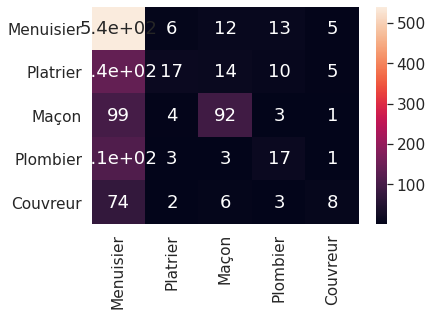

In [55]:
random_rf=RandomForestClassifier(criterion='gini',max_depth=20, max_features='sqrt', n_estimators=1000)
random_rf.fit(X_trainB,y_trainB)
y_randomB=random_rf.predict(X_test)
metrics_mesures(y_test,y_randomB)

In [52]:
# GridSearchCV
param_grid={'criterion': ['gini'],
 'max_depth': [20,30,40],
 'max_features': ['sqrt'],
 'n_estimators': [900,1000,1100]}

Grid_search_rf=GridSearchCV(estimator=RandomForestClassifier(),param_grid=param_grid,cv=3,scoring=f1,return_train_score=True,verbose=4)

In [53]:
Grid_search_rf.fit(X_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=900; total time=   5.3s
[CV 2/3] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=900; total time=   4.8s
[CV 3/3] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=900; total time=   5.0s
[CV 1/3] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=1000; total time=   5.8s
[CV 2/3] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=1000; total time=   6.7s
[CV 3/3] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=1000; total time=   6.9s
[CV 1/3] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=1100; total time=   4.5s
[CV 2/3] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=1100; total time=   7.7s
[CV 3/3] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=1100; total time=   9.0s
[CV 1/3] END criterion=gini, max_depth=30, 

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [20, 30, 40],
                         'max_features': ['sqrt'],
                         'n_estimators': [900, 1000, 1100]},
             return_train_score=True, scoring=<function f1 at 0x7fc6bfcb0820>,
             verbose=4)

In [54]:
print(Grid_search_rf.best_params_)
print(Grid_search_rf.best_estimator_)

{'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 1000}
RandomForestClassifier(max_depth=20, max_features='sqrt', n_estimators=1000)


We have the same model as in RandomizeSearcCV..

### XGBOOST

In [56]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [57]:
import xgboost as xgb

params={
    'learning_rate':[0.05,0.10,0.15,0.20,0.25,0.30],
    'max_depth':[3,6,9,15,20],
    'min_child_weight':[1,3,5,7],
    'colsample_bytree':[0.3,0.4,0.5,0.7]
}

clf = xgb.XGBClassifier(objective="multi:softmax")
random_xgb=RandomizedSearchCV(clf,param_distributions=params,n_iter=5,scoring=f1,n_jobs=-1,cv=5,verbose=3)
random_xgb.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/euclide03/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           reg_alpha=None, reg_lambda=None,
                                           scale_pos_weight=None,
                                       

In [58]:
print(random_xgb.best_params_)
print(random_xgb.best_estimator_)

{'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 0.4}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


Accuracy: 0.5591939546599496
F1 score: 0.5591939546599496
Recall: 0.5591939546599496
Precision: 0.5591939546599496




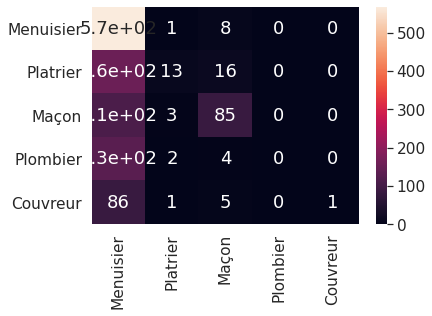

In [59]:
random_clf=xgb.XGBClassifier(min_child_weight= 3,colsample_bytree=0.4, learning_rate=0.03, max_depth=3,
              objective='multi:softmax',eval_metric='mlogloss')

random_clf.fit(X_train,y_train)
y_xg=random_clf.predict(X_test)

metrics_mesures(y_test,y_xg)

/home/euclide03/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.5667506297229219
F1 score: 0.5667506297229219
Recall: 0.5667506297229219
Precision: 0.5667506297229219




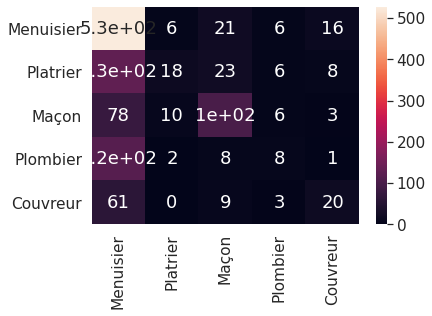

In [60]:
# for balanced data
random_clf.fit(X_trainB,y_trainB)
y_xgB=random_clf.predict(X_test)

metrics_mesures(y_test,y_xgB)

# Comparasion between Models

Looking to metrics, we assume that the SVM model, gives up the best results.

# Predictions

In [62]:
data_to_complete=pd.merge(client_to_predict, null_professions, how='inner',on='client_id').drop_duplicates()
data_to_complete.shape

(1209, 103)

In [63]:
data_to_complete_ids=data_to_complete["client_id"]
data_to_complete=data_to_complete.drop(["client_id","Profession"],1)
data_to_complete.head()

,product_id_21.0,product_id_12.0,product_id_3.0,product_id_90.0,product_id_86.0,product_id_56.0,product_id_97.0,product_id_7.0,product_id_35.0,product_id_92.0,...,product_id_51.0,product_id_31.0,product_id_23.0,product_id_5.0,product_id_17.0,product_id_4.0,product_id_15.0,product_id_88.0,product_id_38.0,product_id_100.0
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)
y_pred = lin_clf.predict(data_to_complete)

In [65]:
y_pred = pd.DataFrame({'Professions':y_pred}) 
map_dict = {1: 'Menuisier',2:'Platrier',3:'Maçon',4:'Plombier',5:'Couvreur'}
y_pred["Professions"] = y_pred["Professions"].map(map_dict)
y_pred.head()

,Professions
0,Menuisier
1,Menuisier
2,Platrier
3,Platrier
4,Menuisier


In [66]:
data_to_complete=pd.concat([data_to_complete_ids, y_pred], axis=1)

In [70]:
data_to_complete.to_csv("data_to_complete1")